# Check with Gao Data
verify the rmg calculated thermo by extrapolating the H to 0K against the data from Gao (2016)

In [1]:
!which python

/work/westgroup/ChrisB/miniconda3/envs/rmg_thesis/bin/python


In [2]:
import sys
import os
import re
import numpy
import pandas as pd
import sys
# sys.path.append('/work/westgroup/ChrisB/_04_thesis/rmg_thesis/RMG-Py/')
print(sys.path)
from rmgpy.species import Species

import matplotlib.pyplot as plt
import numpy as np
# Species("OH")

['/work/westgroup/ChrisB/_04_thesis/Thesis_repo/validation_data', '/work/westgroup/ChrisB/_04_thesis/rmg_thesis/RMG-Py', '/work/westgroup/ChrisB/_04_thesis/Thesis_repo/validation_data', '/work/westgroup/ChrisB/miniconda3/envs/rmg_thesis/lib/python37.zip', '/work/westgroup/ChrisB/miniconda3/envs/rmg_thesis/lib/python3.7', '/work/westgroup/ChrisB/miniconda3/envs/rmg_thesis/lib/python3.7/lib-dynload', '', '/home/blais.ch/.local/lib/python3.7/site-packages', '/work/westgroup/ChrisB/miniconda3/envs/rmg_thesis/lib/python3.7/site-packages', '/work/westgroup/ChrisB/miniconda3/envs/rmg_thesis/lib/python3.7/site-packages/chemprop-0.0.1-py3.7.egg', '/work/westgroup/ChrisB/miniconda3/envs/rmg_thesis/lib/python3.7/site-packages/descriptastorus-2.0.0.32-py3.7.egg', '/work/westgroup/ChrisB/miniconda3/envs/rmg_thesis/lib/python3.7/site-packages/IPython/extensions', '/home/blais.ch/.ipython']


In [3]:
# load the thermodynamics database
from rmgpy.data.thermo import ThermoDatabase
thermoDatabase = ThermoDatabase()
libraries = ['surfaceThermoPt111']
if sys.platform == "darwin":
    thermoDatabase.load(path="/Users/blais.ch/Documents/_01_code/RMG_env_1/RMG-database/input/thermo", libraries = libraries)
else: 
    thermoDatabase.load(path='/work/westgroup/ChrisB/_04_thesis/rmg_thesis/RMG-database/input/thermo', libraries = libraries)
    
thermoDatabase.load_surface()
pt_library = thermoDatabase.libraries['surfaceThermoPt111']

In [4]:
class SpeciesDat():
    def __init__(self, adj_list): 
        
        self.rmg_spec = Species().from_adjacency_list(adj_list)
     
        self.new_thermo = {}
        self.Hf_rmg = {}
        
        # gao data structures
        self.Hf_lit = {}
        self.Hf_gao = {}
        self.metal_list = []
        
        # delta Hfs
        self.dH_rmg = {}
        self.dH_lit = {}
        self.dH_gao = {}

    def scale_rmg_thermo(self, metal_from='Pt', metal_to='Rh', 
                         facet_from='111', facet_to='211'):
        
        # need to redefine species every time so we don't stack Hf
        self.rmg_spec.thermo, _, _ = thermoDatabase.get_thermo_data_from_library(self.rmg_spec,pt_library)
        self.rmg_spec.generate_resonance_structures()
        self.spec_thermo = self.rmg_spec.thermo.to_thermo_data()
        self.rmg_spec.thermo = self.spec_thermo
        self.Hf_old = (self.rmg_spec.thermo.H298.value_si)/9.68e4
        new_metal_str = f"{metal_to}({facet_to})"
        self.new_thermo[new_metal_str] = thermoDatabase.correct_binding_energy_advanced(self.spec_thermo, 
                                                                           self.rmg_spec, 
                                                                           metal_to_scale_from=metal_from,
                                                                           metal_to_scale_to=metal_to, 
                                                                           facet_to_scale_from=facet_from, 
                                                                           facet_to_scale_to=facet_to)
        self.Hf_rmg[new_metal_str] = self.new_thermo[new_metal_str].H298.value_si/9.68e4
        self.Hf_rmg[new_metal_str]
        
    def scale_all_thermo(self): 
        """
        scale all of the thermo corresponding to each metal in gao data
        """
        if len(self.metal_list) > 0:
            for metal, facet in self.metal_list:
                self.scale_rmg_thermo(metal_from='Pt', metal_to=metal, 
                         facet_from='111', facet_to=facet)
        else: 
            raise Exception("please load gao data first")
                
                
    
    def set_gao_hf(self, hf): 
        self.gao_hf_df = hf
        self.gao_hf_df.columns = ["DFTcal", "predicted"]
        for row in self.gao_hf_df.iterrows(): 
            self.Hf_lit[row[0]] = row[1]['DFTcal']
            self.Hf_gao[row[0]] = row[1]['predicted']
            metal = row[0].split("(")[0]
            facet = row[0].split("(")[1].replace(")", "")
            self.metal_list.append((metal, facet))

            
    def get_dh_rmg(self, surface_to = "Rh(211)"):
        """
        get diff between pt111 database value and scaled value
        """
        dH = self.Hf_rmg[surface_to] - self.Hf_old
        return dH
    
    def get_all_dHs(self, surface_from="Pt(111)"):
        
        Hf_rmg_from = self.Hf_rmg[surface_from]
        Hf_gao_from = self.Hf_gao[surface_from]
        Hf_lit_from = self.Hf_lit[surface_from]
        
        for surface in self.Hf_lit.keys():
            self.dH_rmg[surface] = self.Hf_rmg[surface] - Hf_rmg_from
            self.dH_gao[surface] = self.Hf_gao[surface] - Hf_gao_from
            self.dH_lit[surface] = self.Hf_lit[surface] - Hf_lit_from
            
    
    def get_dh_lit(self, metal_from='Pt', metal_to='Rh', 
                         facet_from='111', facet_to='211'):
        """
        get diff between literature values 
        """
        old_metal_str = f"{metal_from}({facet_from})"
        new_metal_str = f"{metal_to}({facet_to})"
        dH = self.Hf_lit[new_metal_str] - self.Hf_lit[old_metal_str]
        return dH 
    
    
    def plot_dhs(self, spec, 
                 fig_path = "/work/westgroup/ChrisB/_04_thesis/Thesis_repo/validation_data/plots/parity_dH_dEb/"):

        fig, ax = plt.subplots(1,2, figsize=(15, 7.5))

        ########################
        # plot rmg
        ########################
        y_rmg = list(self.dH_rmg.values())
        x = list(self.dH_lit.values())
        labels_rmg = list(self.dH_rmg.keys())

        ax[0].set_title(f"parity for predicted vs dft $\Delta H$ from Pt for {spec}*")
        ax[0].set_ylabel(r"$\Delta H_{f}^{298K}$ for rmg species from Pt(111) (eV)")
        ax[0].set_xlabel(r"$\Delta E_{B}^{0K}$ for lit species from Pt(111) (eV)")
        ax[0].plot(x,y_rmg, ".")

        # plot parity line
        buff = 0.1
        par_x = np.array([min(y_rmg) - buff, max(y_rmg) + buff])
        par_y = np.array([min(y_rmg) - buff, max(y_rmg) + buff])

        ax[0].plot(par_x, par_y, "-.", color="k")

        # fill between for 0.3 eV error on RMG
        err_y_plus = par_y + 0.3
        err_y_minus = par_y - 0.3

        ax[0].fill_between(par_x, err_y_plus, err_y_minus, color="k", alpha = 0.1)

        # label the metals
        for i, label in enumerate(labels_rmg):
            ax[0].annotate(label, (x[i],y_rmg[i]))


        ##############################
        # plot gao
        ##############################
        y_gao = list(self.Hf_gao.values())
        x = list(self.Hf_lit.values())
        labels_gao = list(self.dH_gao.keys())

        ax[1].set_title(f"Gao vs DFT $E_b$ for {spec}*")
        ax[1].set_ylabel(r"$E_{B}^{0K}$ for Gao species (eV)")
        ax[1].set_xlabel(r"$E_{B}^{0K}$ for lit species (eV)")
        ax[1].plot(x,y_gao, ".")

        # plot parity line
        buff = 0.1
        par_x = np.array([min(y_gao) - buff, max(y_gao) + buff])
        par_y = np.array([min(y_gao) - buff, max(y_gao) + buff])


        ax[1].plot(par_x, par_y, "-.", color="k")

        # fill between for 0.3 eV error on RMG
        # err_x = par_x
        err_y_plus = par_y + 0.3
        # err_x_minus = par_x - 0.3
        err_y_minus = par_y - 0.3

        ax[1].fill_between(par_x, err_y_plus, err_y_minus, color="k", alpha = 0.1)

        # label the metals
        for i, label in enumerate(labels_gao):
            ax[1].annotate(label, (x[i],y_gao[i]))
        
        figname = os.path.join(fig_path, f"parity_rmgvgao_{spec}.pdf")
        plt.savefig(figname, bbox_inches='tight')

'C'

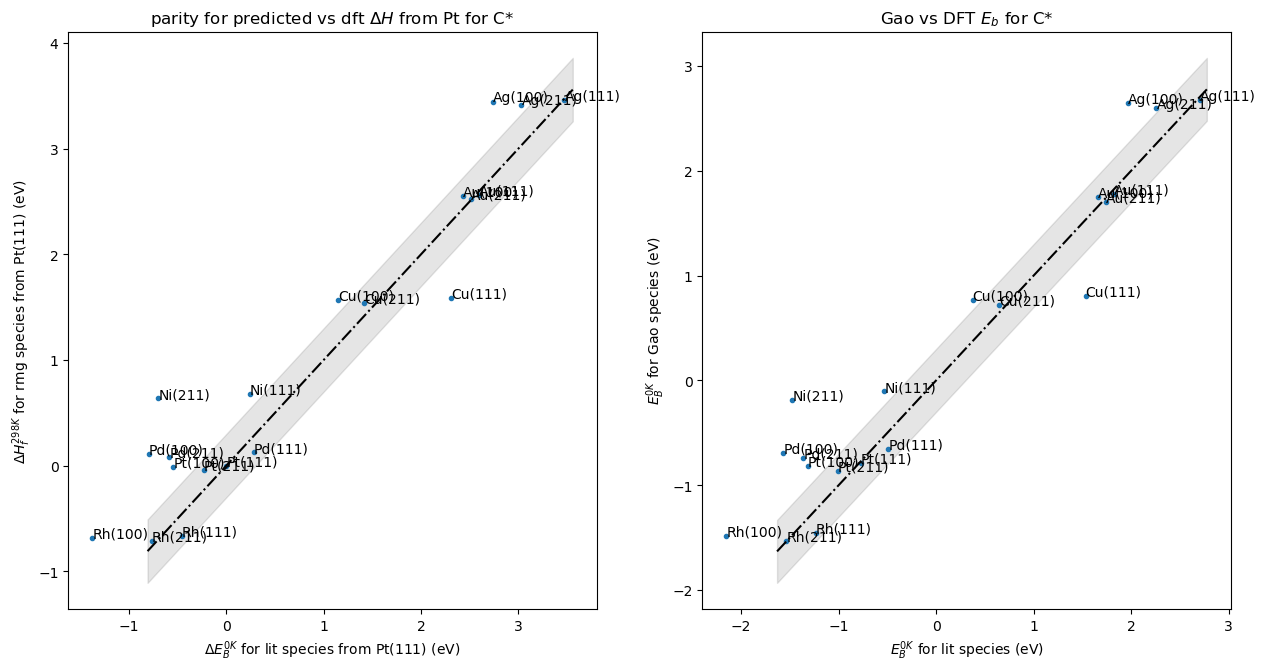

In [5]:
gao_species = {}

# C
spec = 'C'
adj = """
1 C u0 p0 c0 {2,Q}
2 X u0 p0 c0 {1,Q}
"""
gao_species[spec] = SpeciesDat(adj)
gao_species[spec].set_gao_hf(
    pd.read_excel("./gao_calcs.xlsx", sheet_name = "Fig. 7", index_col=0, skiprows=[0], nrows=20, usecols="C:E"))

surface_from = "Pt(111)"
gao_species[spec].scale_all_thermo()
gao_species[spec].get_all_dHs()
display(spec,gao_species[spec].rmg_spec)
gao_species[spec].plot_dhs(spec)

'C'

'CH'

'CH2'

'CH3'

'CO'

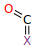

'COOH'

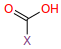

'CHO'

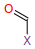

'COH'

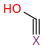

'CHOH'

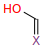

'N'

'NH'

'NNH2'

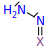

'NH2'

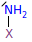

'O'

'OH'

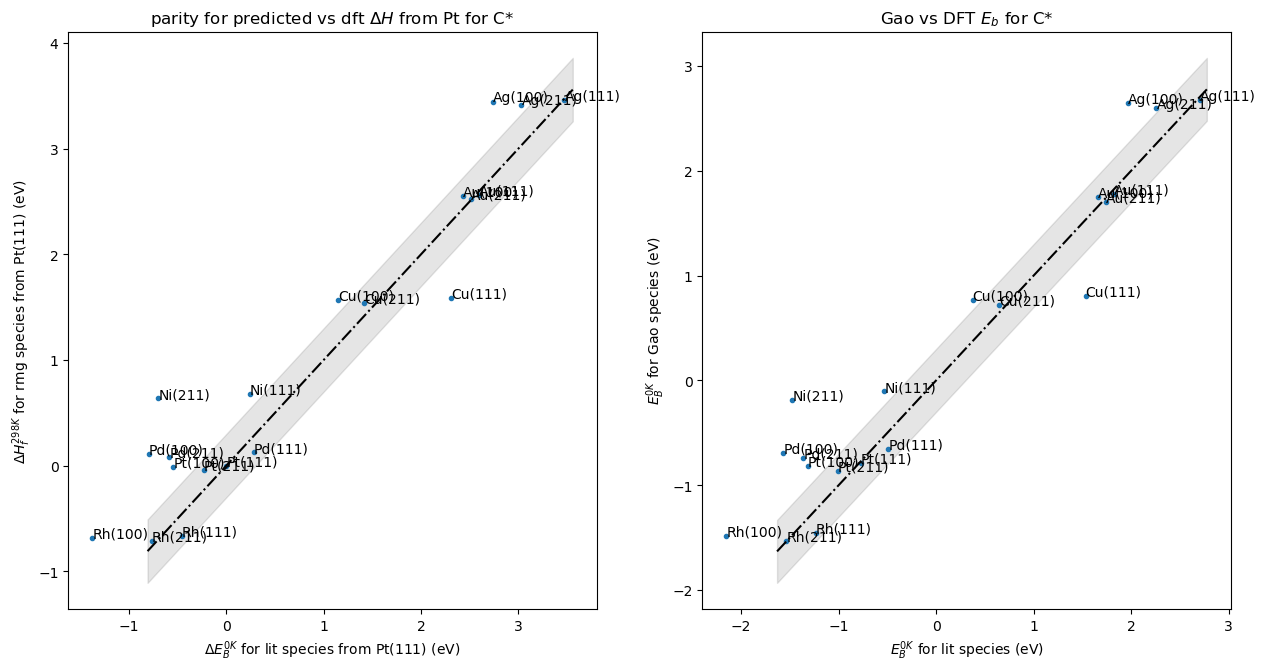

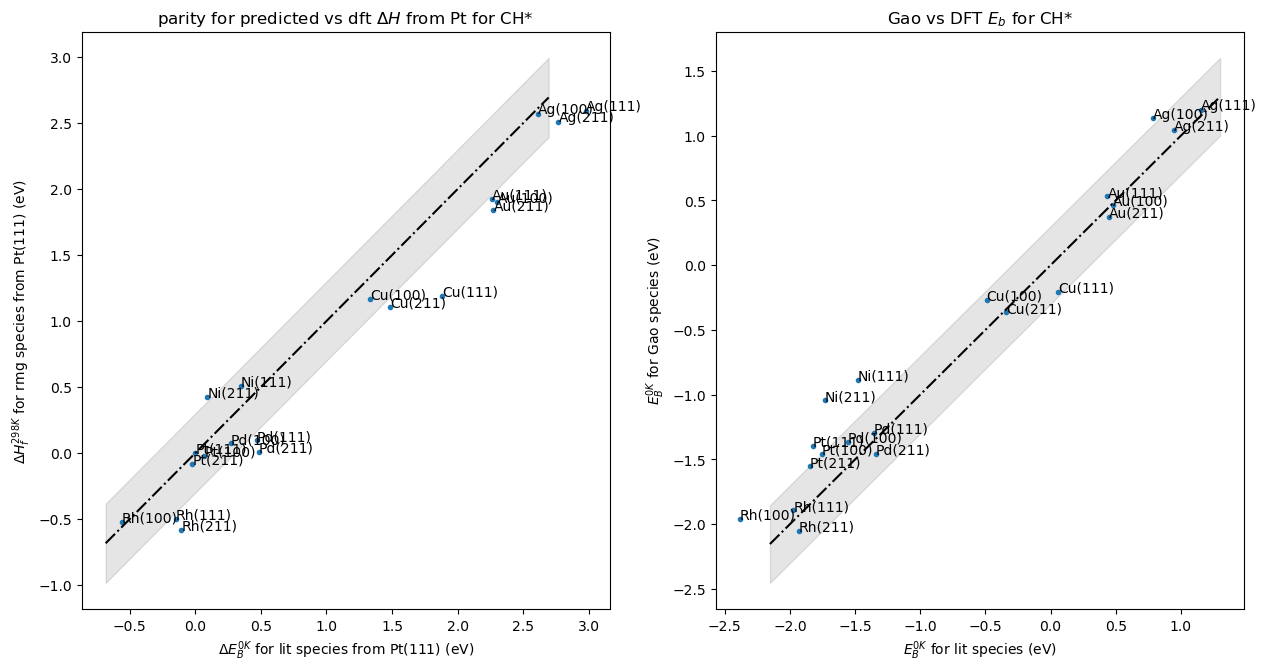

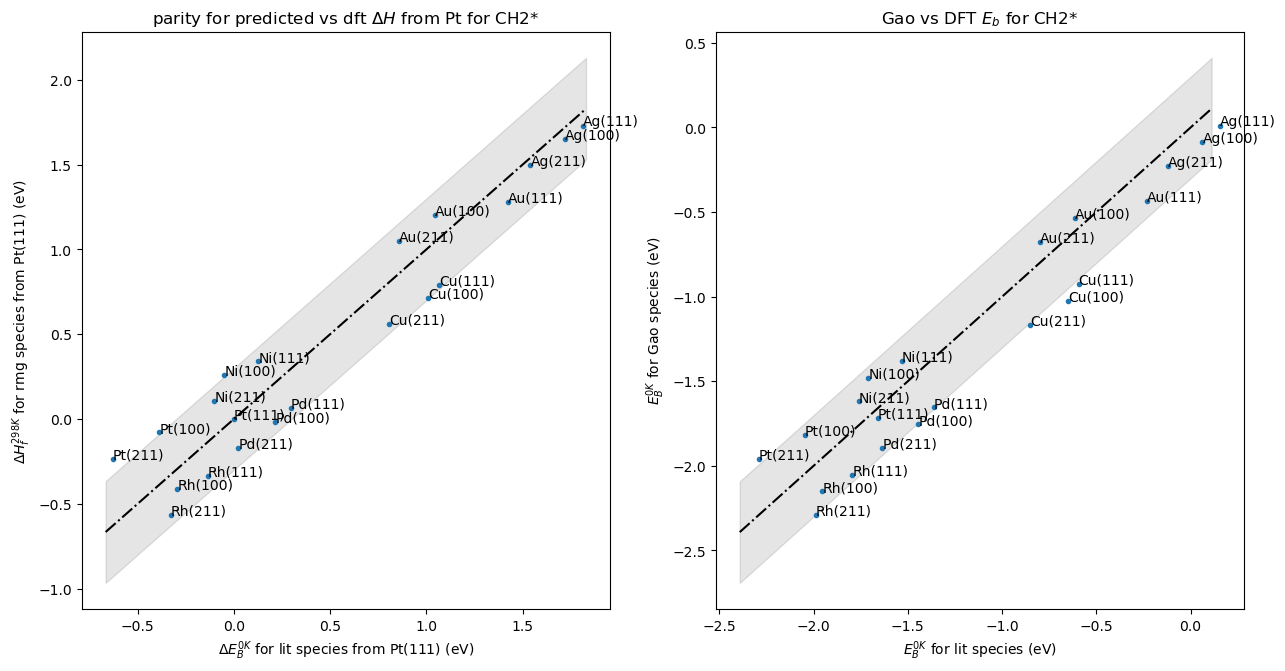

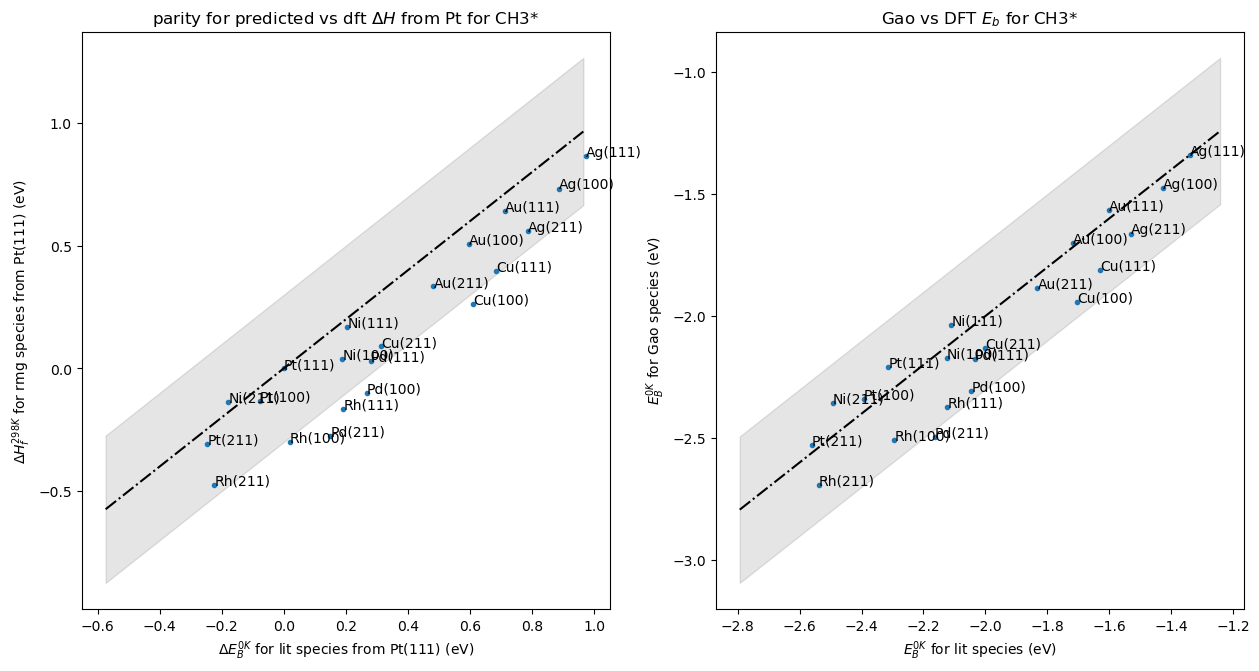

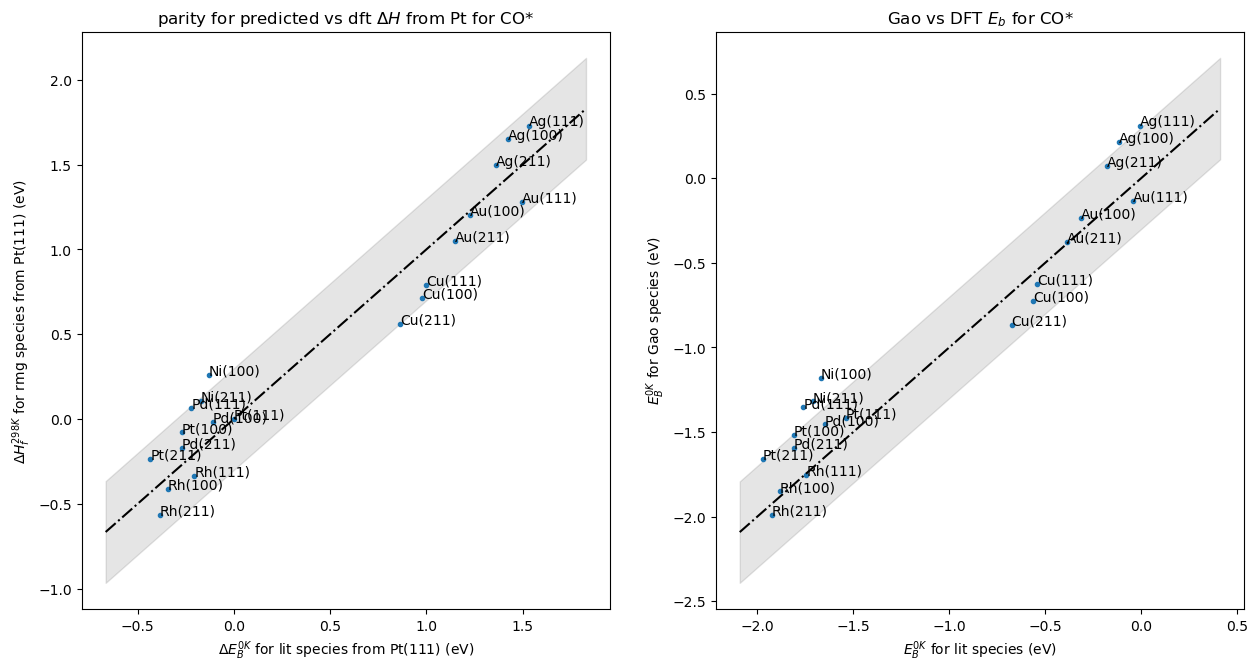

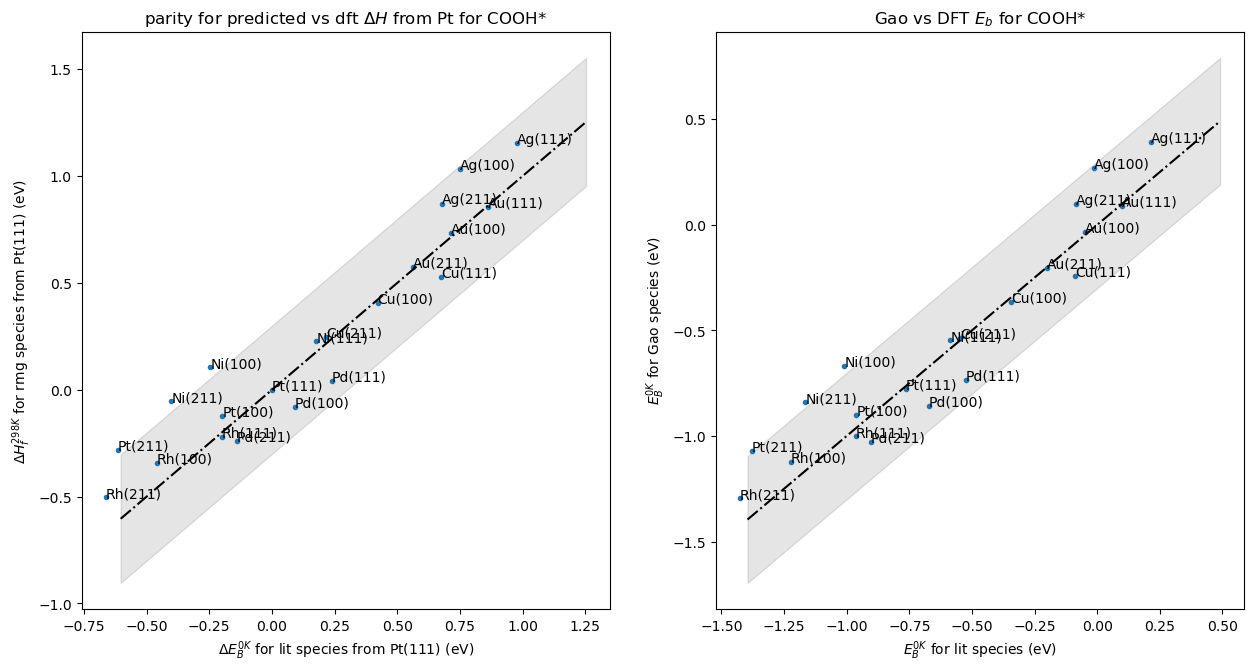

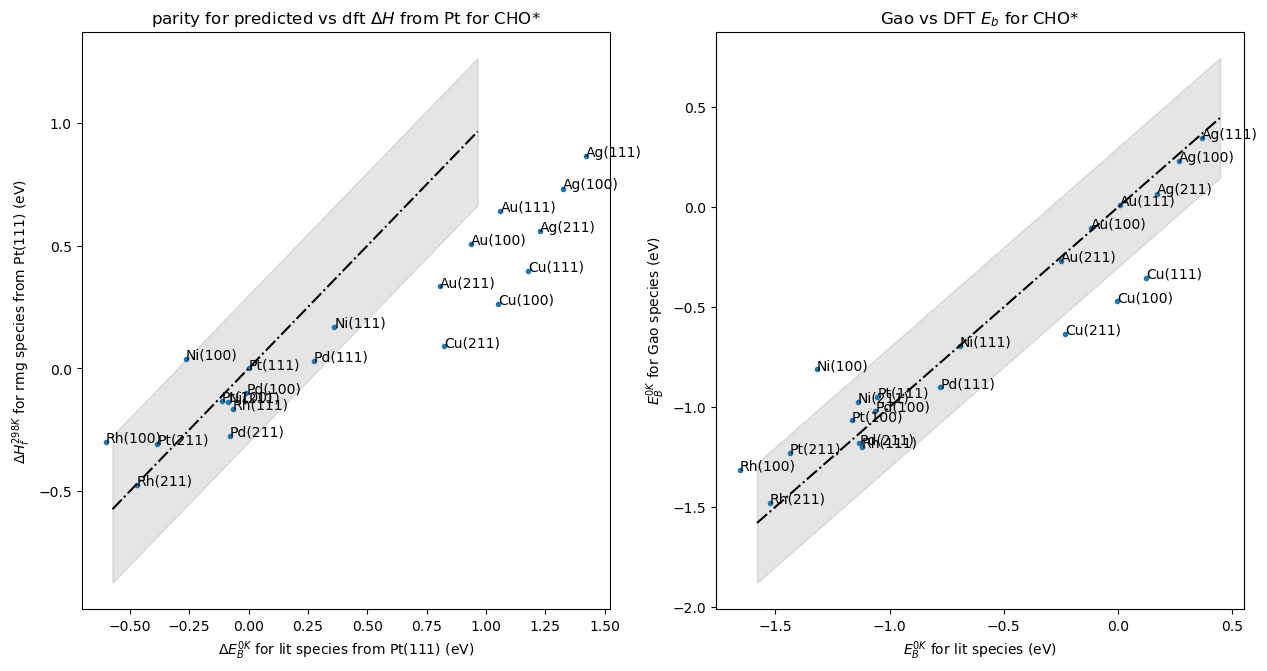

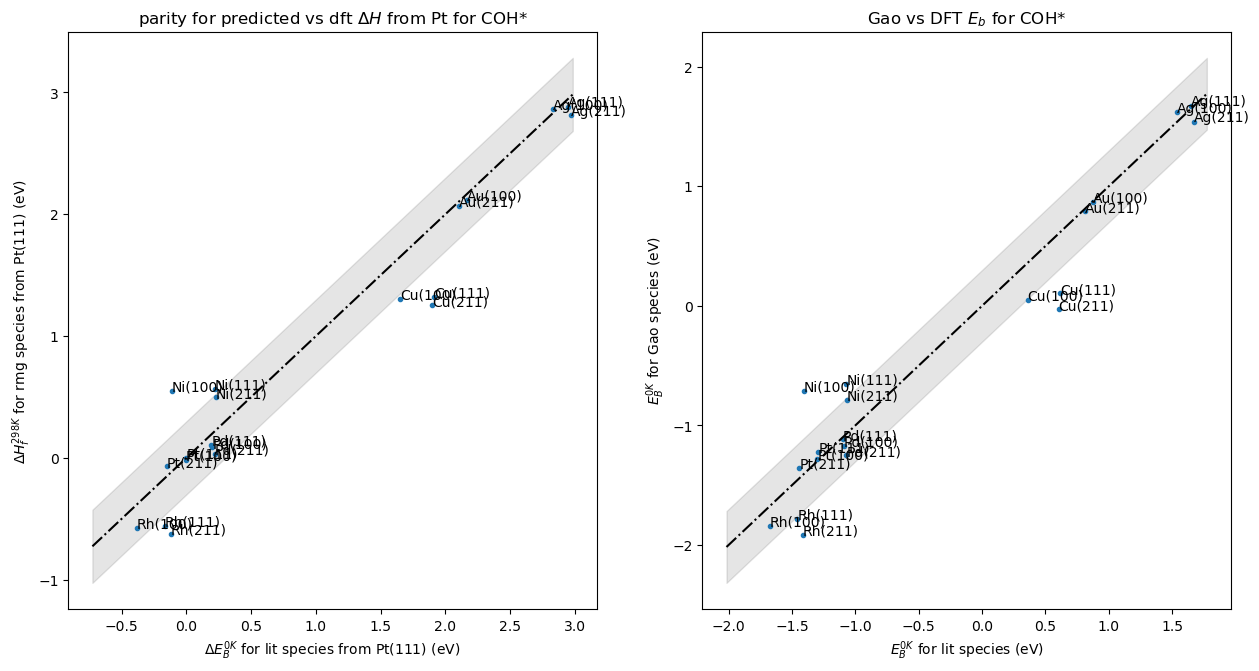

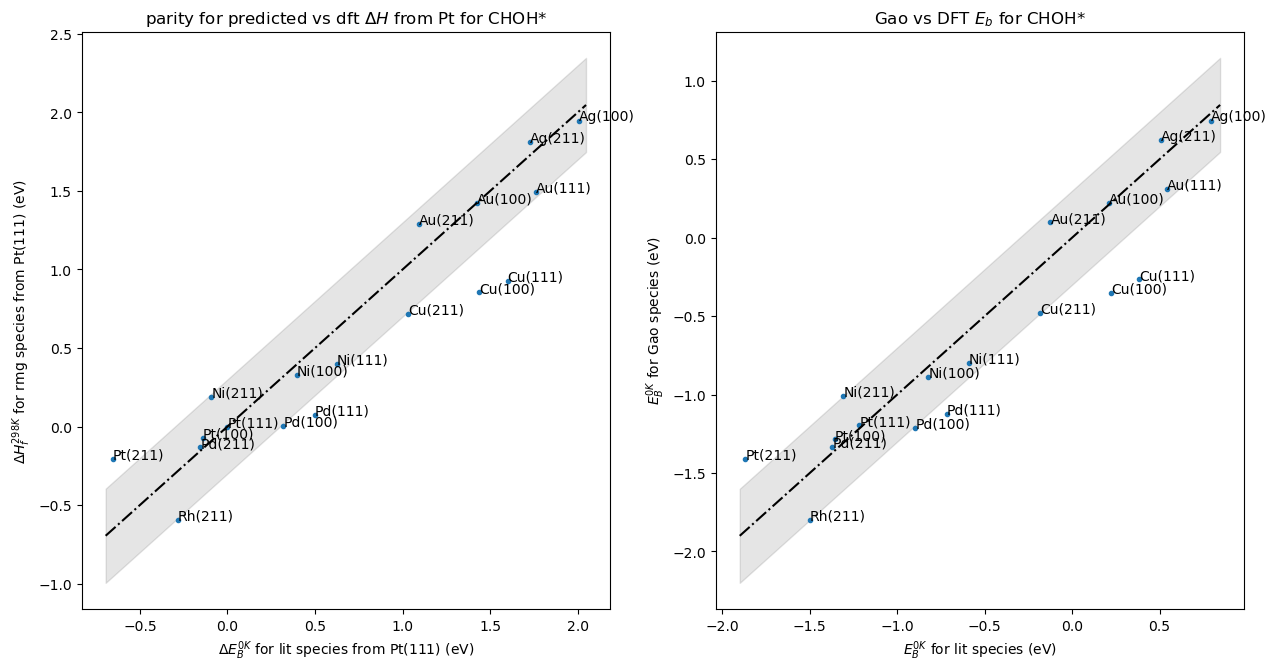

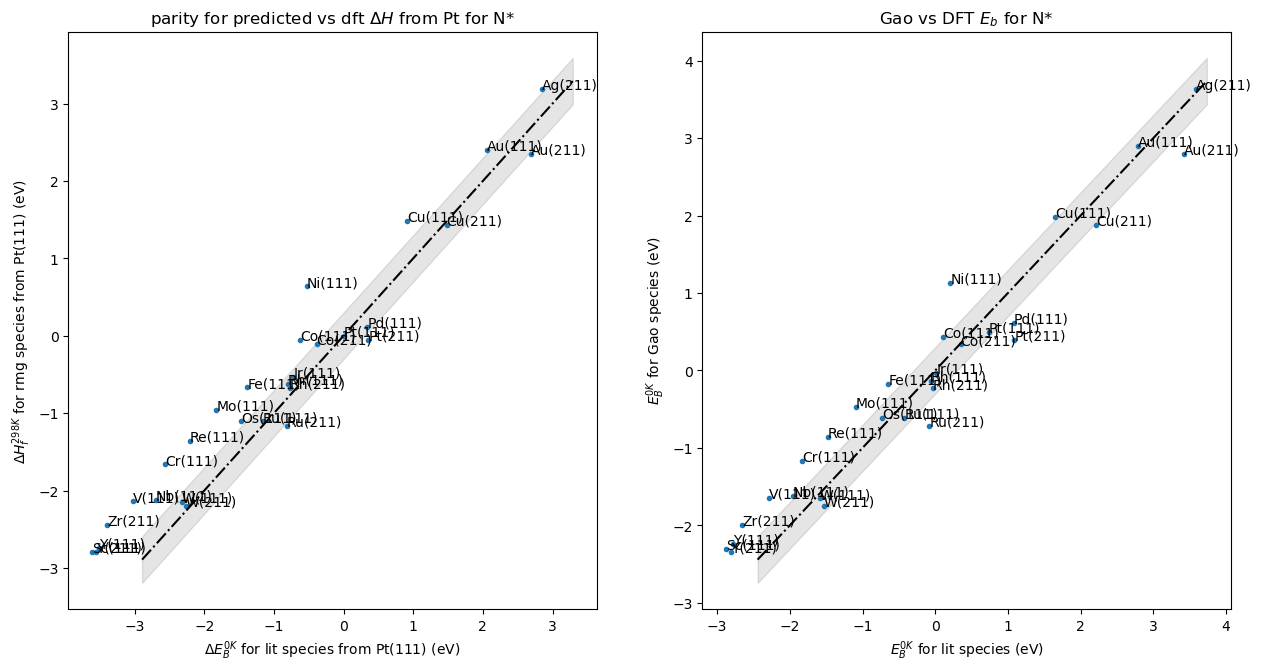

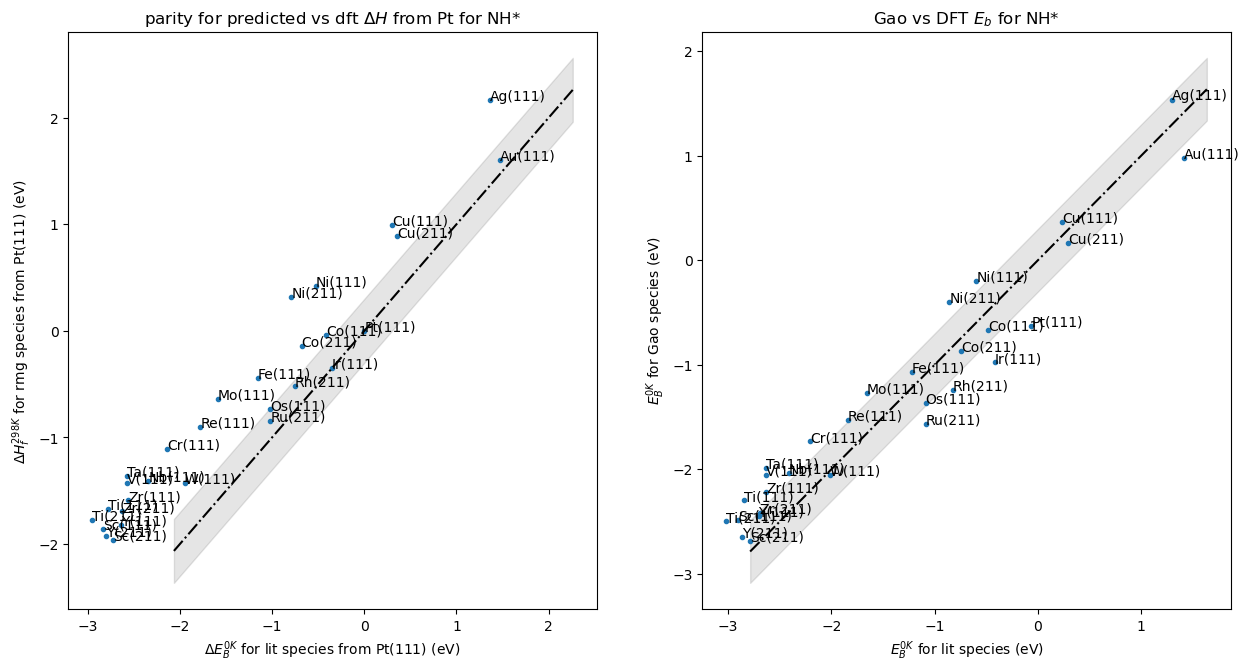

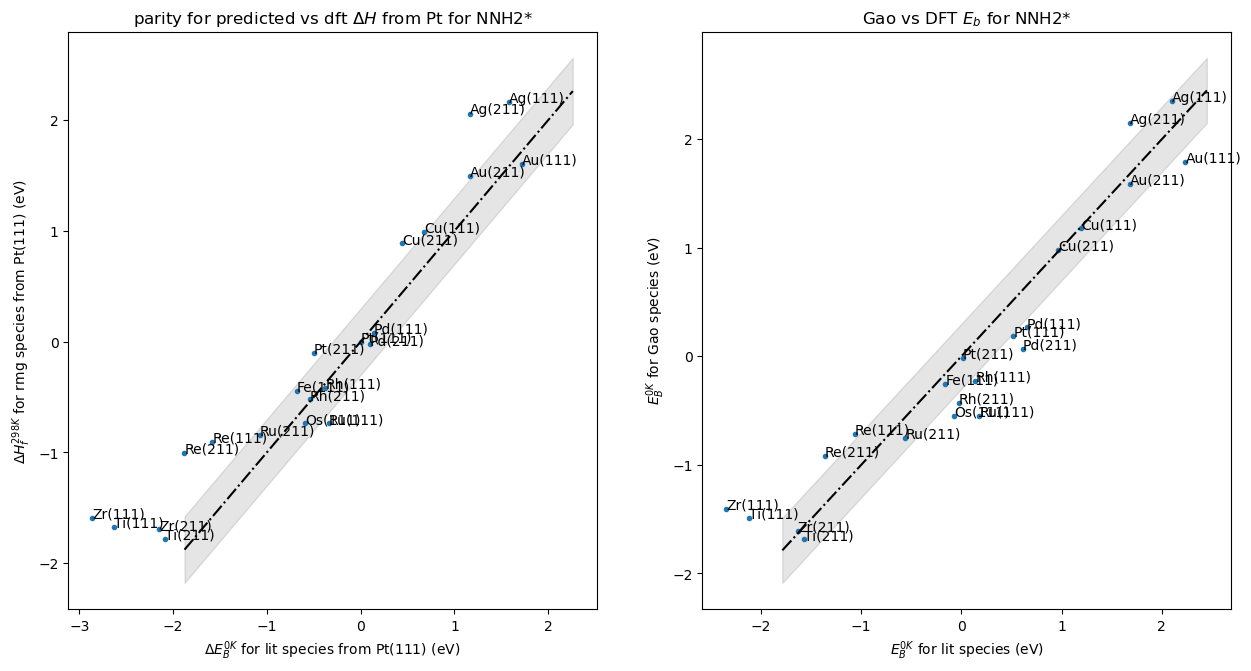

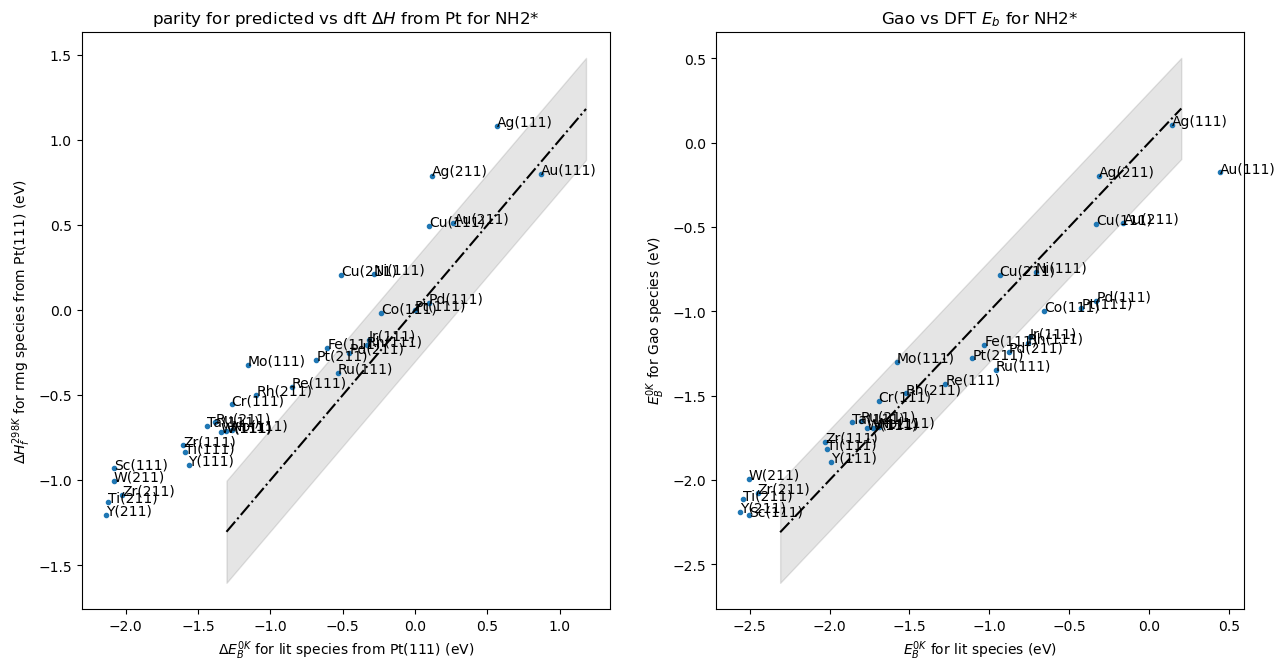

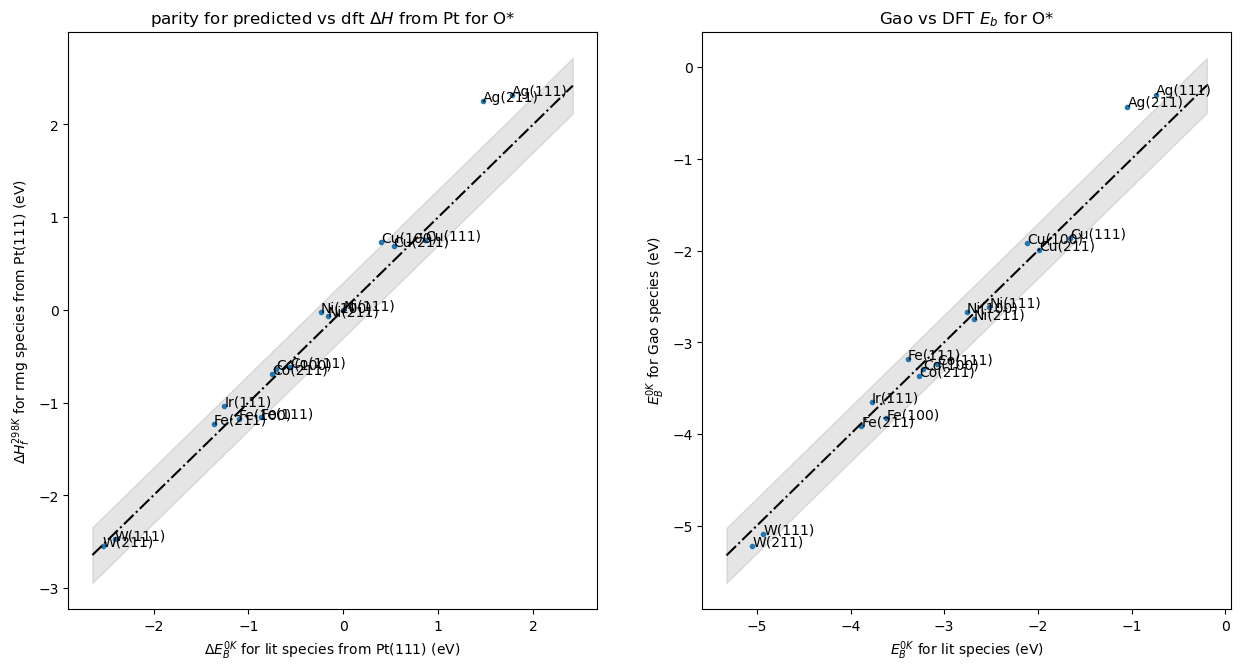

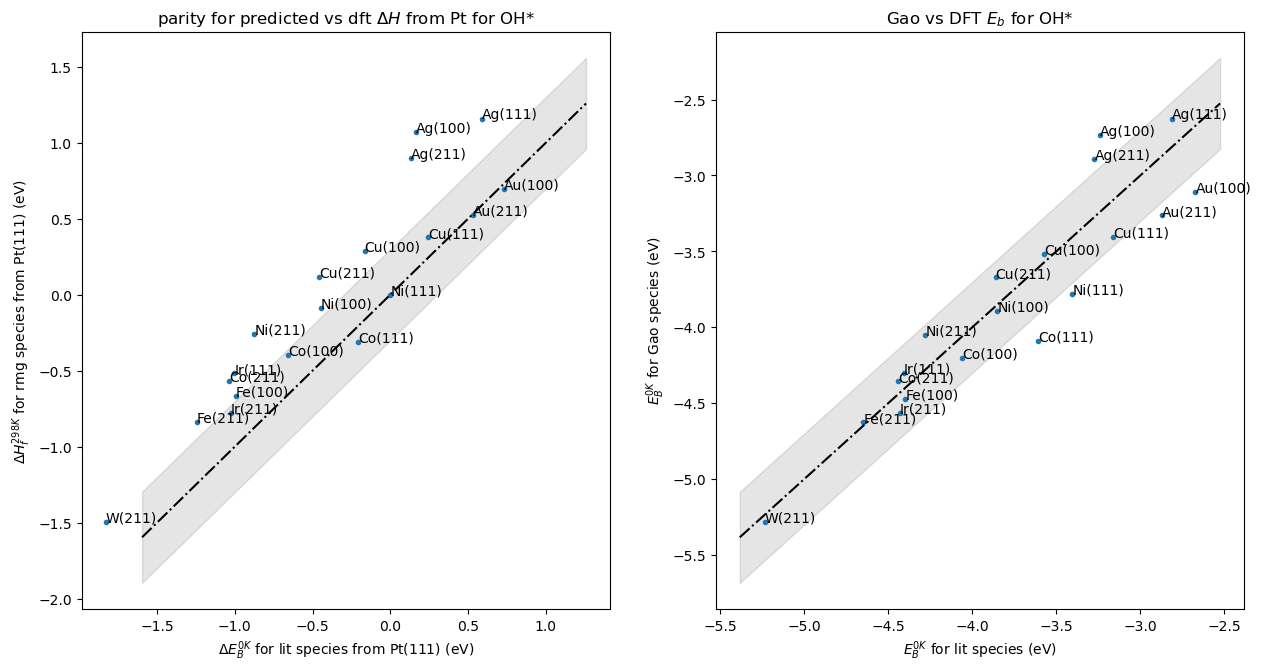

In [6]:
gao_species = {}

# C
spec = 'C'
adj = """
1 C u0 p0 c0 {2,Q}
2 X u0 p0 c0 {1,Q}
"""
gao_species[spec] = SpeciesDat(adj)
gao_species[spec].set_gao_hf(
    pd.read_excel("./gao_calcs.xlsx", sheet_name = "Fig. 7", index_col=0, skiprows=[0], nrows=20, usecols="C:E"))

surface_from = "Pt(111)"
gao_species[spec].scale_all_thermo()
gao_species[spec].get_all_dHs()
display(spec,gao_species[spec].rmg_spec)
gao_species[spec].plot_dhs(spec)


# CH
spec = 'CH'
adj = """
1 C u0 p0 c0 {2,S} {3,T}
2 H u0 p0 c0 {1,S}
3 X u0 p0 c0 {1,T}
"""
gao_species[spec] = SpeciesDat(adj)
gao_species[spec].set_gao_hf(
    pd.read_excel("./gao_calcs.xlsx", sheet_name = "Fig. 7", index_col=0, skiprows=[0], nrows=20, usecols="H:J"))

gao_species[spec].scale_all_thermo()
gao_species[spec].get_all_dHs()

display(spec,gao_species[spec].rmg_spec)
gao_species[spec].plot_dhs(spec)

# CH2
spec = 'CH2'
adj = """
1 C u0 p0 c0 {2,S} {3,S} {4,D}
2 H u0 p0 c0 {1,S}
3 H u0 p0 c0 {1,S}
4 X u0 p0 c0 {1,D}
"""
gao_species[spec] = SpeciesDat(adj)
gao_species[spec] = SpeciesDat(adj)
gao_species[spec].set_gao_hf(
    pd.read_excel("./gao_calcs.xlsx", sheet_name = "Fig. 7", index_col=0, skiprows=[0], nrows=21, usecols="M:O"))

gao_species[spec].scale_all_thermo()
gao_species[spec].get_all_dHs()

display(spec,gao_species[spec].rmg_spec)
gao_species[spec].plot_dhs(spec)

# CH3
spec = 'CH3'
adj = """
1 C u0 p0 c0 {2,S} {3,S} {4,S} {5,S}
2 H u0 p0 c0 {1,S}
3 H u0 p0 c0 {1,S}
4 H u0 p0 c0 {1,S}
5 X u0 p0 c0 {1,S}
"""
gao_species[spec] = SpeciesDat(adj)
gao_species[spec].set_gao_hf(
    pd.read_excel("./gao_calcs.xlsx", sheet_name = "Fig. 7", index_col=0, skiprows=[0], nrows=21, usecols="R:T"))

gao_species[spec].scale_all_thermo()
gao_species[spec].get_all_dHs()

display(spec,gao_species[spec].rmg_spec)
gao_species[spec].plot_dhs(spec)

# CO
spec = 'CO'
adj = """
1 C u0 p0 c0 {2,D} {3,D} 
2 O u0 p2 c0 {1,D}
3 X u0 p0 c0 {1,D}
"""
gao_species[spec] = SpeciesDat(adj)
gao_species[spec].set_gao_hf(
    pd.read_excel("./gao_calcs.xlsx", sheet_name = "Fig. 7", index_col=0, skiprows=[0], nrows=20, usecols="W:Y"))

gao_species[spec].scale_all_thermo()
gao_species[spec].get_all_dHs()

display(spec,gao_species[spec].rmg_spec)
gao_species[spec].plot_dhs(spec)

# COOH
spec = 'COOH'
adj = """
1 C u0 p0 c0 {2,D} {3,S} {5,S}
2 O u0 p2 c0 {1,D}
3 O u0 p2 c0 {1,S} {4,S}
4 H u0 p0 c0 {3,S}
5 X u0 p0 c0 {1,S}
"""
gao_species[spec] = SpeciesDat(adj)
gao_species[spec].set_gao_hf(
    pd.read_excel("./gao_calcs.xlsx", sheet_name = "Fig. 7", index_col=0, skiprows=[0], nrows=21, usecols="AB:AD"))

gao_species[spec].scale_all_thermo()
gao_species[spec].get_all_dHs()

display(spec,gao_species[spec].rmg_spec)
gao_species[spec].plot_dhs(spec)

# CHO
spec = 'CHO'
adj = """
1 C u0 p0 c0 {2,D} {3,S} {4,S}
2 O u0 p2 c0 {1,D}
3 H u0 p0 c0 {1,S}
4 X u0 p0 c0 {1,S}
"""
gao_species[spec] = SpeciesDat(adj)
gao_species[spec].set_gao_hf(
    pd.read_excel("./gao_calcs.xlsx", sheet_name = "Fig. 7", index_col=0, skiprows=[0], nrows=21, usecols="AG:AI"))

gao_species[spec].scale_all_thermo()
gao_species[spec].get_all_dHs()

display(spec,gao_species[spec].rmg_spec)
gao_species[spec].plot_dhs(spec)

# COH
spec = 'COH'
adj = """
1 C u0 p0 c0 {2,S} {4,T}
2 O u0 p2 c0 {1,S} {3,S}
3 H u0 p0 c0 {2,S}
4 X u0 p0 c0 {1,T}
"""
gao_species[spec] = SpeciesDat(adj)
gao_species[spec].set_gao_hf(
    pd.read_excel("./gao_calcs.xlsx", sheet_name = "Fig. 7", index_col=0, skiprows=[0], nrows=20, usecols="AL:AN"))

gao_species[spec].scale_all_thermo()
gao_species[spec].get_all_dHs()

display(spec,gao_species[spec].rmg_spec)
gao_species[spec].plot_dhs(spec)

# CHOH
spec = 'CHOH'
adj = """
1 C u0 p0 c0 {2,S} {4,S} {5,D}
2 O u0 p2 c0 {1,S} {3,S}
3 H u0 p0 c0 {2,S}
4 H u0 p0 c0 {1,S}
5 X u0 p0 c0 {1,D}
"""
gao_species[spec] = SpeciesDat(adj)
gao_species[spec].set_gao_hf(
    pd.read_excel("./gao_calcs.xlsx", sheet_name = "Fig. 7", index_col=0, skiprows=[0], nrows=18, usecols="AQ:AS"))

gao_species[spec].scale_all_thermo()
gao_species[spec].get_all_dHs()

display(spec,gao_species[spec].rmg_spec)
gao_species[spec].plot_dhs(spec)

# N
spec = 'N'
adj = """
1 N u0 p1 c0 {2,T} 
2 X u0 p0 c0 {1,T}
"""
gao_species[spec] = SpeciesDat(adj)
gao_species[spec].set_gao_hf(
    pd.read_excel("./gao_calcs.xlsx", sheet_name = "Fig. 7", index_col=0, skiprows=[0], nrows=29, usecols="BB:BD"))

gao_species[spec].scale_all_thermo()
gao_species[spec].get_all_dHs()

display(spec,gao_species[spec].rmg_spec)
gao_species[spec].plot_dhs(spec)

# NH
spec = 'NH'
adj = """
1 N u0 p1 c0 {2,S} {3,D} 
2 H u0 p0 c0 {1,S}
3 X u0 p0 c0 {1,D}
"""
gao_species[spec] = SpeciesDat(adj)
gao_species[spec].set_gao_hf(
    pd.read_excel("./gao_calcs.xlsx", sheet_name = "Fig. 7", index_col=0, skiprows=[0], nrows=29, usecols="BG:BI"))

gao_species[spec].scale_all_thermo()
gao_species[spec].get_all_dHs()

display(spec,gao_species[spec].rmg_spec)
gao_species[spec].plot_dhs(spec)

# NNH2 
spec = 'NNH2'
adj = """
1 N u0 p1 c0 {2,S} {3,S} {4,S}
2 N u0 p1 c0 {1,S} {5,D} 
3 H u0 p0 c0 {1,S}
4 H u0 p0 c0 {1,S}
5 X u0 p0 c0 {2,D}
"""
gao_species[spec] = SpeciesDat(adj)
gao_species[spec].set_gao_hf(
    pd.read_excel("./gao_calcs.xlsx", sheet_name = "Fig. 7", index_col=0, skiprows=[0], nrows=22, usecols="BL:BN"))

gao_species[spec].scale_all_thermo()
gao_species[spec].get_all_dHs()

display(spec,gao_species[spec].rmg_spec)
gao_species[spec].plot_dhs(spec)

# NH2
spec = 'NH2'
adj = """
1 N u0 p1 c0 {2,S} {3,S} {4,S} 
2 H u0 p0 c0 {1,S}
3 H u0 p0 c0 {1,S}
4 X u0 p0 c0 {1,S}
"""
gao_species[spec] = SpeciesDat(adj)
gao_species[spec].set_gao_hf(
    pd.read_excel("./gao_calcs.xlsx", sheet_name = "Fig. 7", index_col=0, skiprows=[0], nrows=34, usecols="BQ:BS"))

gao_species[spec].scale_all_thermo()
gao_species[spec].get_all_dHs()

display(spec,gao_species[spec].rmg_spec)
gao_species[spec].plot_dhs(spec)

# (no data for Pt111 for the O and OH so using 
spec = 'O'
adj = """
1 O u0 p2 c0 {2,D}
2 X u0 p0 c0 {1,D}
"""
skiprows = [0] + [i for i in range(2,43)]
gao_species[spec] = SpeciesDat(adj)
gao_species[spec].set_gao_hf(
    pd.read_excel("./gao_calcs.xlsx", sheet_name = "Fig. 7", index_col=0, skiprows=skiprows, nrows=17, usecols="CM:CO"))

gao_species[spec].scale_all_thermo()
gao_species[spec].get_all_dHs(surface_from="Ni(111)")

display(spec,gao_species[spec].rmg_spec)
gao_species[spec].plot_dhs(spec)

# OH
spec = 'OH'
adj = """
1 O u0 p2 c0 {2,S} {3,S}
2 H u0 p0 c0 {1,S}
3 X u0 p0 c0 {1,S}
"""
gao_species[spec] = SpeciesDat(adj)
skiprows = [0] + [i for i in range(2,91)]
gao_species[spec].set_gao_hf(
    pd.read_excel("./gao_calcs.xlsx", sheet_name = "Fig. 7", index_col=0, skiprows=skiprows, nrows=19, usecols="CR:CT"))

gao_species[spec].scale_all_thermo()
gao_species[spec].get_all_dHs(surface_from="Ni(111)")

display(spec,gao_species[spec].rmg_spec)
gao_species[spec].plot_dhs(spec)

# # OOH
# spec = 'OOH'
# adj = """
# 1 O u0 p2 c0 {2,S} {4,S}
# 2 O u0 p2 c0 {1,S} {3,S}
# 3 H u0 p0 c0 {2,S}
# 4 X u0 p0 c0 {1,S}
# """
# gao_species[spec] = SpeciesDat(adj)
# gao_species[spec].set_gao_hf(
#     pd.read_excel("./gao_calcs.xlsx", sheet_name = "Fig. 7", index_col=0, skiprows=[0], nrows=20, usecols=""))

# gao_species[spec].scale_all_thermo()
# gao_species[spec].get_all_dHs(surface_from="Ni(111)")

# display(spec,gao_species[spec].rmg_spec)
# gao_species[spec].plot_dhs(spec)

# # OCH3
# spec = 'OCH3'
# adj = """
# 1 O u0 p2 c0 {2,S} {6,S}
# 2 C u0 p0 c0 {1,S} {3,S} {4,S} {5,S}
# 3 H u0 p0 c0 {2,S}
# 4 H u0 p0 c0 {2,S}
# 5 H u0 p0 c0 {2,S}
# 6 X u0 p0 c0 {1,S}
# """
# gao_species[spec] = SpeciesDat(adj)
# gao_species[spec].set_gao_hf(
#     pd.read_excel("./gao_calcs.xlsx", sheet_name = "Fig. 7", index_col=0, skiprows=[0], nrows=20, usecols=""))

# gao_species[spec].scale_all_thermo()
# gao_species[spec].get_all_dHs(surface_from="Ni(111)")

# display(spec,gao_species[spec].rmg_spec)
# gao_species[spec].plot_dhs(spec)

In [12]:
gao_species['O'].Hf_rmg['Cu(211)'], gao_species['O'].Hf_old

(-0.13123163009580496, -1.3828982967624714)

In [8]:
gao_species['O'].Hf_rmg

['Hf_gao',
 'Hf_lit',
 'Hf_old',
 'Hf_rmg',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'dH_gao',
 'dH_lit',
 'dH_rmg',
 'gao_hf_df',
 'get_all_dHs',
 'get_dh_lit',
 'get_dh_rmg',
 'metal_list',
 'new_thermo',
 'plot_dhs',
 'rmg_spec',
 'scale_all_thermo',
 'scale_rmg_thermo',
 'set_gao_hf',
 'spec_thermo']

## check gao species 

In [6]:
gao_species['C'].spec_thermo.comment

' Binding energy corrected by Gao relations (C scaled from Pt(111) at 111_fcc_hollow to Au(100) at site 100_hollow with alpha=0.80)'

In [ ]:
(5-1)/(5+1) - (2)/(4+2)

In [13]:
-3.62 - 38.99/96.8                                                                                                                                                                                                                                          
    

-4.022789256198347

In [6]:
df = pd.read_excel("./gao_calcs.xlsx", sheet_name = "Fig. 7", index_col=0, skiprows=[0], nrows=20, usecols="C:E")

In [13]:
au_be = np.mean([
    df["DFTcal"]["Au(111)"], 
    df["DFTcal"]["Au(211)"],
    df["DFTcal"]["Au(100)"]
])
au_be

alpha = 0.8


1.74346

In [11]:
df

,DFTcal,predicted
Surfaces,,
Ni(111),-0.52971,-0.104018
Cu(111),1.53210,0.802237
Rh(111),-1.23337,-1.450394
Pd(111),-0.48851,-0.656136
Ag(111),2.70000,2.675317
Pt(111),-0.77410,-0.783728
Au(111),1.82587,1.781272
Ni(211),-1.47333,-0.184018
Cu(211),0.64237,0.722237


In [ ]:
# toy example
cn0 = 6.62
cn1 = 6.955
cn2 = 5.91

alpha = 0.8

